# Data

In [1]:
dat = read.table("cookies.txt", header = TRUE)
head(dat)

chips,location
12,1
12,1
6,1
13,1
12,1
12,1


In [2]:
unique(dat$location)

[1] 1 2 3 4 5

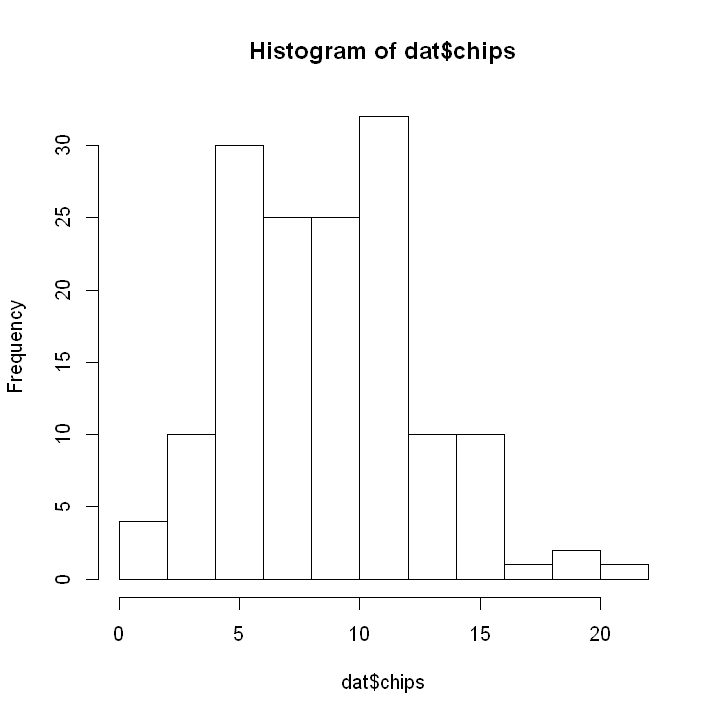

In [3]:
options(repr.plot.width=6, repr.plot.height=6)

hist(dat$chips)

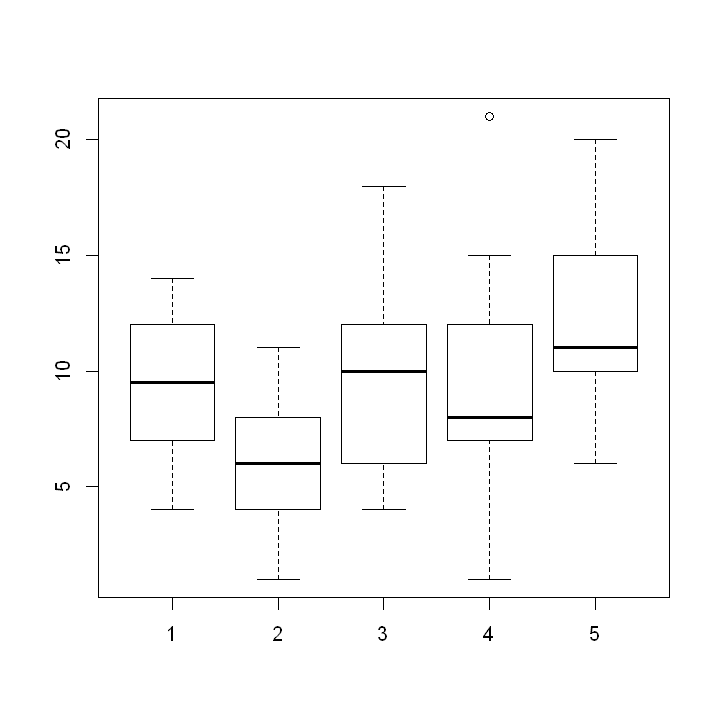

In [4]:
boxplot(chips ~ location, data = dat)

# Prior Predictive Check


Before implementing the model, we need to select prior distributions for α and β, the hyperparameters governing the gamma distribution for the λ parameters. First, think about what the λ’s represent. For location j, λj is the expected number of chocolate chips per cookie. Hence, α and β control the distribution of these means between locations. The mean of this gamma distribution will represent the overall mean of number of chips for all cookies. The variance of this gamma distribution controls the variability between locations. If this is high, the mean number of chips will vary widely from location to location. If it is small, the mean number of chips will be nearly the same from location to location.

To see the effects of different priors on the distribution of λ’s, we can simulate. Suppose we try independent exponential priors for α and β.

<img src="hierarchy.PNG"/>

In [5]:
set.seed(112)

In [6]:
n_sim = 1e3

alpha_prior = rexp(n_sim, rate = 1.0/2.0)
beta_prior = rexp(n_sim, rate = 5.0)

mu_prior = (alpha_prior ^ 2) / (beta_prior ^ 2)
sig_prior = sqrt( alpha_prior/ (beta_prior ^ 2) )

In [7]:
summary(mu_prior)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0       11       93    47997      713 37405797 

In [8]:
summary(sig_prior)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.169    3.702    8.194   29.394   19.331 4660.062 

In [9]:
# After simulating from the priors for α and β, we can use those samples to simulate further down the hierarchy.

lambda_prior = rgamma(n = n_sim, 
                      shape = alpha_prior, 
                      rate = beta_prior)

summary(lambda_prior)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    1.073    6.838   40.477   25.373 5211.686 

In [10]:
# Or for a prior predictive reconstruction of the original data set:

lambda_prior = rgamma(n = 5, 
                      shape = alpha_prior, 
                      rate = beta_prior)

summary(lambda_prior)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.767   4.737  11.836  16.499  17.928  46.226 

In [11]:
y_prior = rpois(n = 150, lambda = rep(lambda_prior, each=30))

y_prior

[1]  7  4  4  3  9  7  1  2  4  3  5  4  3  5  5  3  7  6  4  5  2  3  6  7  8
 [26]  6  8  3  3  3 20 14 16 15 18 26 14 20 16 18 17 19 28 18 11 20 10 17 22 17
 [51] 14 22 17 25 23 21 18 13 11 20 12 13 13 15 11 14  9  9 11  9 11 15  7  9  8
 [76]  9 12 16 12 22 10 11 14 17 10  6  9 17 11 10  3  2  1  4  0  2  2  0  1  0
[101]  2  1  1  0  1  0  0  4  0  1  2  1  4  2  1  0  2  0  5  3 43 42 47 39 52
[126] 50 53 50 49 54 44 42 40 53 51 31 47 44 61 53 56 40 41 49 48 54 49 52 48 43

Because these priors have high variance and are somewhat noninformative, they produce unrealistic predictive distributions. Still, enough data would overwhelm the prior, resulting in useful posterior distributions. Alternatively, we could tweak and simulate from these prior distributions until they adequately represent our prior beliefs. Yet another approach would be to re-parameterize the gamma prior, which we’ll demonstrate as we fit the model.

# JAGS Model

In [12]:
library("coda")
library("rjags")

Warning message:
"package 'coda' was built under R version 3.4.4"Warning message:
"package 'rjags' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [13]:
head(dat)

chips,location
12,1
12,1
6,1
13,1
12,1
12,1


<img src="hierarchy.PNG"/>

In [14]:
mod_str = " model {
    # Model's Likelihood Hierarchy
    for(i in 1:length(chips)){
        chips[i] ~ dpois(lam[location[i]])
    }

    for(j in 1:max(location)){
        lam[j] ~ dgamma(alpha, beta)
    }
    
    # Priors (in form of mu and sig)

    alpha = mu^2 / sig^2
    beta = mu / sig^2

    mu ~ dgamma(2.0, 1.0/5.0)
    sig ~ dexp(1.0)
} "

In [15]:
set.seed(113)

In [16]:
data_jags = as.list(dat)

In [17]:
params = c("lam", "mu", "sig")

In [18]:
mod = jags.model(textConnection(mod_str), 
                 data = data_jags, 
                 n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 150
   Unobserved stochastic nodes: 7
   Total graph size: 315

Initializing model



In [19]:
update(mod, 1e3)

mod_sim = coda.samples(model = mod, 
                       variable.names = params, 
                       n.iter = 1e4)

mod_csim = as.mcmc(do.call(rbind, mod_sim))

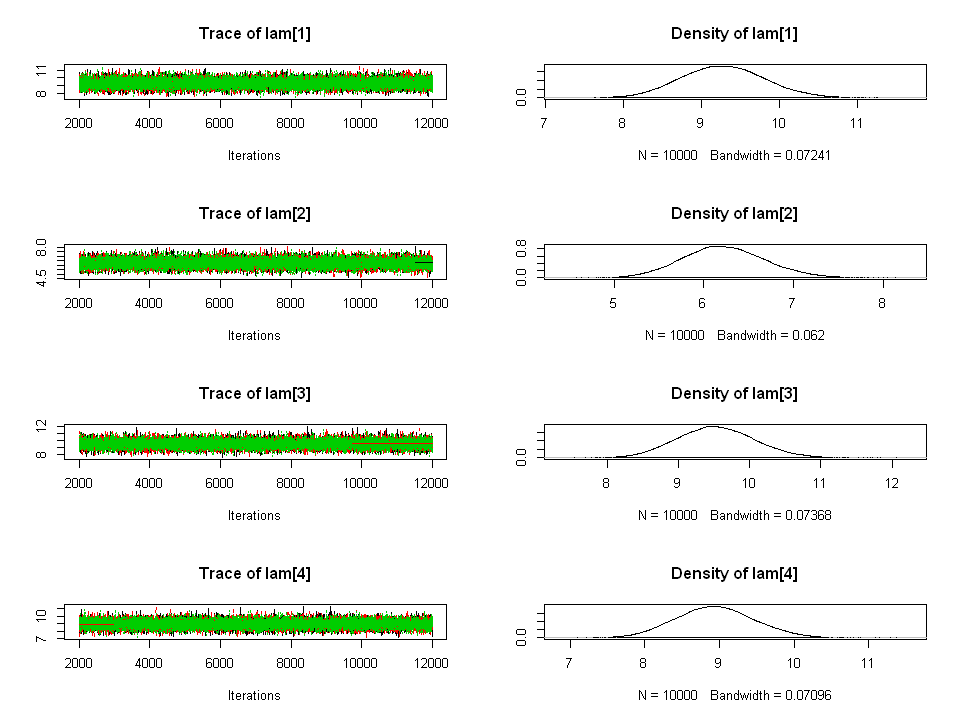

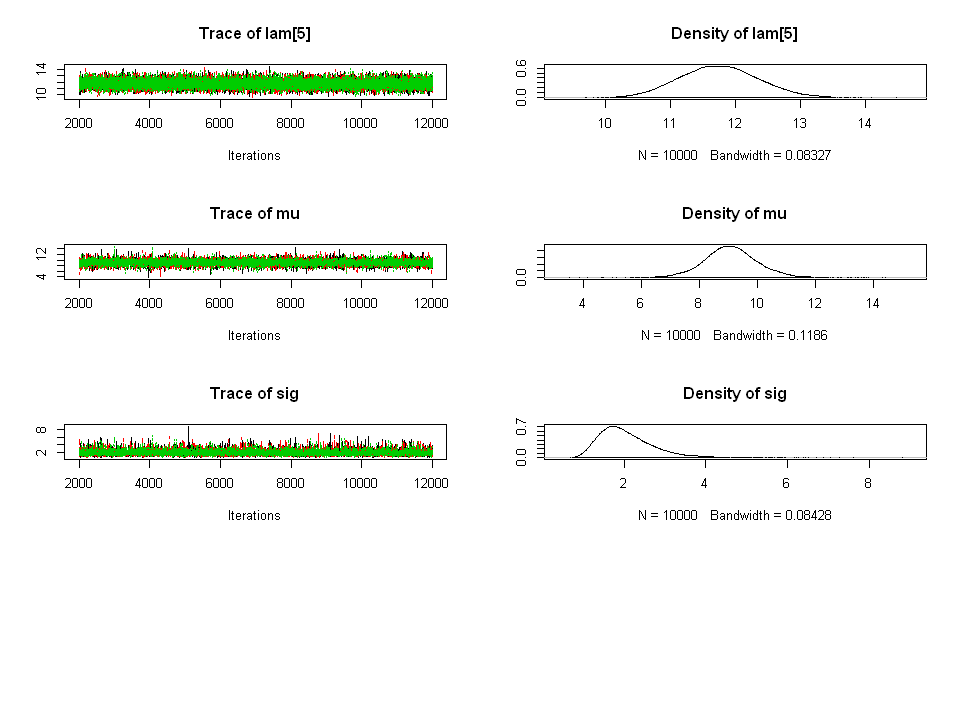

In [20]:
# Convergence Dignosis

options(repr.plot.width = 8, repr.model.height=10)

plot(mod_sim)

In [21]:
# Convergence Dignosis

gelman.diag(mod_sim)
autocorr.diag(mod_sim)
effectiveSize(mod_sim)

Potential scale reduction factors:

       Point est. Upper C.I.
lam[1]          1          1
lam[2]          1          1
lam[3]          1          1
lam[4]          1          1
lam[5]          1          1
mu              1          1
sig             1          1

Multivariate psrf

1

,lam[1],lam[2],lam[3],lam[4],lam[5],mu,sig
Lag 0,1.0000000000,1.000000000,1.000000000,1.0000000000,1.000000000,1.000000000,1.000000000
Lag 1,0.0284118498,0.112904124,0.020633769,0.0191066167,0.056872758,0.368014181,0.570981911
Lag 5,0.0063559360,0.012770716,-0.009500648,0.0006777028,-0.001150007,0.026097797,0.097693729
Lag 10,-0.0005808907,-0.002649832,0.011823858,-0.0016467998,0.002356198,0.003666997,0.023958109
Lag 50,0.0036976033,0.004942986,0.001338190,0.0010566590,-0.011968066,-0.009260772,0.004680512


lam[1]    lam[2]    lam[3]    lam[4]    lam[5]        mu       sig 
27882.732 22280.376 28424.741 29128.810 23034.082 13238.044  7119.861

In [22]:
# Compute Dic

dic = dic.samples(model = mod, n.iter = 1e4)
dic

Mean deviance:  783.7 
penalty 4.805 
Penalized deviance: 788.5 

In [23]:
colMeans(mod_csim)

lam[1]    lam[2]    lam[3]    lam[4]    lam[5]        mu       sig 
 9.281574  6.226794  9.529670  8.944683 11.755160  9.096188  2.074950

# Model checking

After assessing convergence, we can check the fit via residuals. With a hierarchical model, there are now two levels of residuals: the observation level and the location mean level. To simplify, we’ll look at the residuals associated with the posterior means of the parameters.

In [24]:
# First, we have observation residuals, based on the estimates of location means.
# Observation level Residuals

pm_params = colMeans(mod_csim)

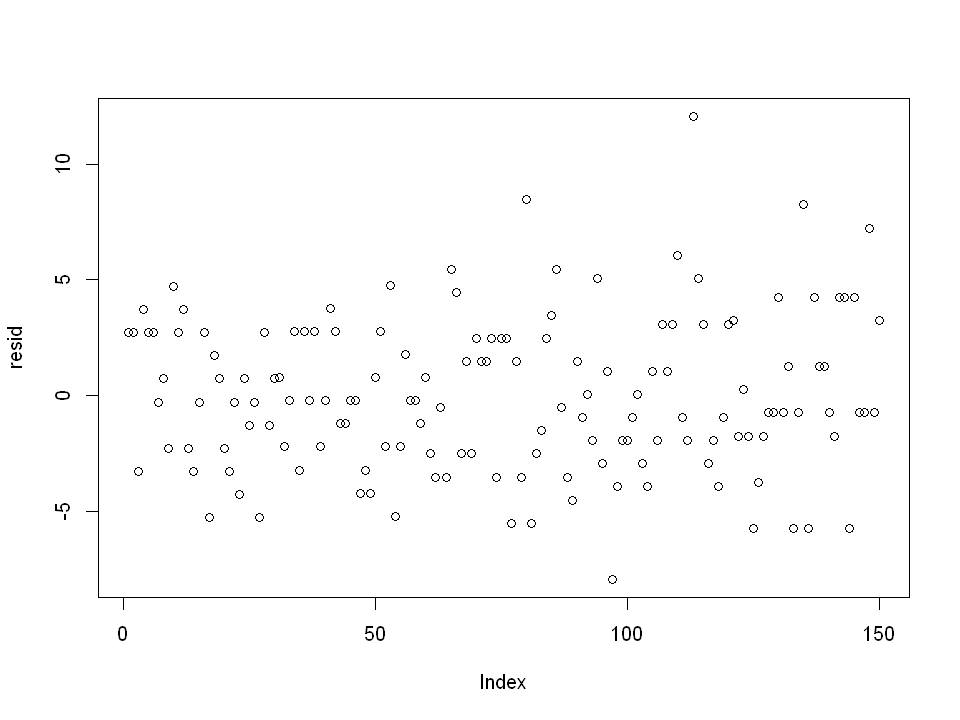

In [25]:
yhat = rep(pm_params[1:5], each = 30)
resid = dat$chips - yhat

options(repr.plot.width = 8, repr.plot.height=6)
plot(resid)

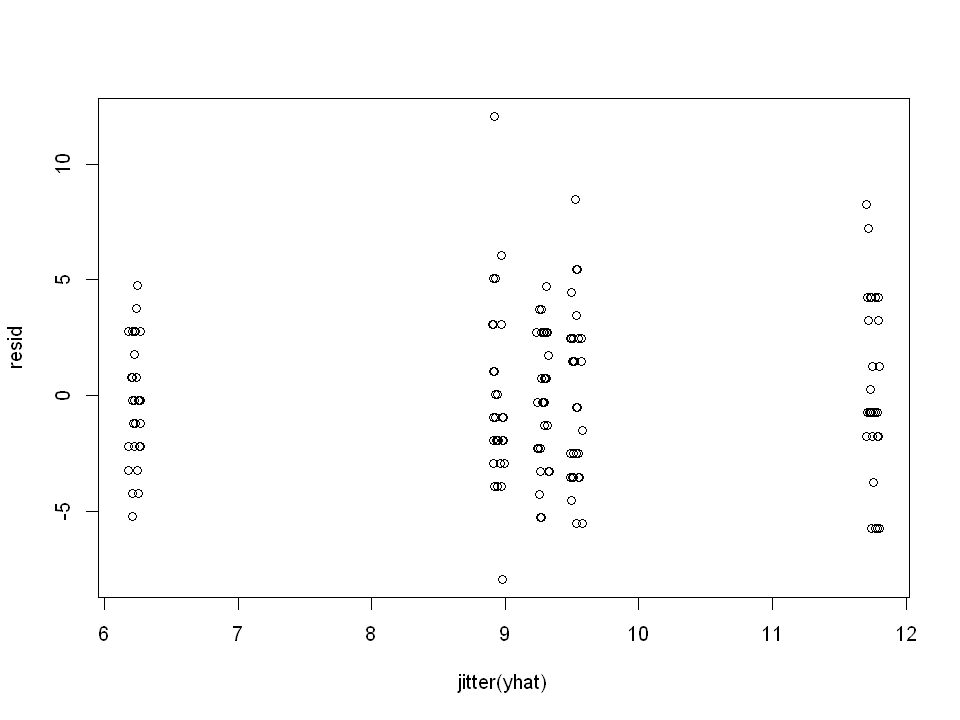

In [26]:
plot(jitter(yhat), resid)

# We can observe here that that variance has incresed as yhat increases like our hypothesis ie. Poisson.

If out hypothesis is not violated then mean will be equal to variance.

In [27]:
var(resid[yhat<7])

[1] 6.447126

In [28]:
var(resid[yhat>11])

[1] 13.72414

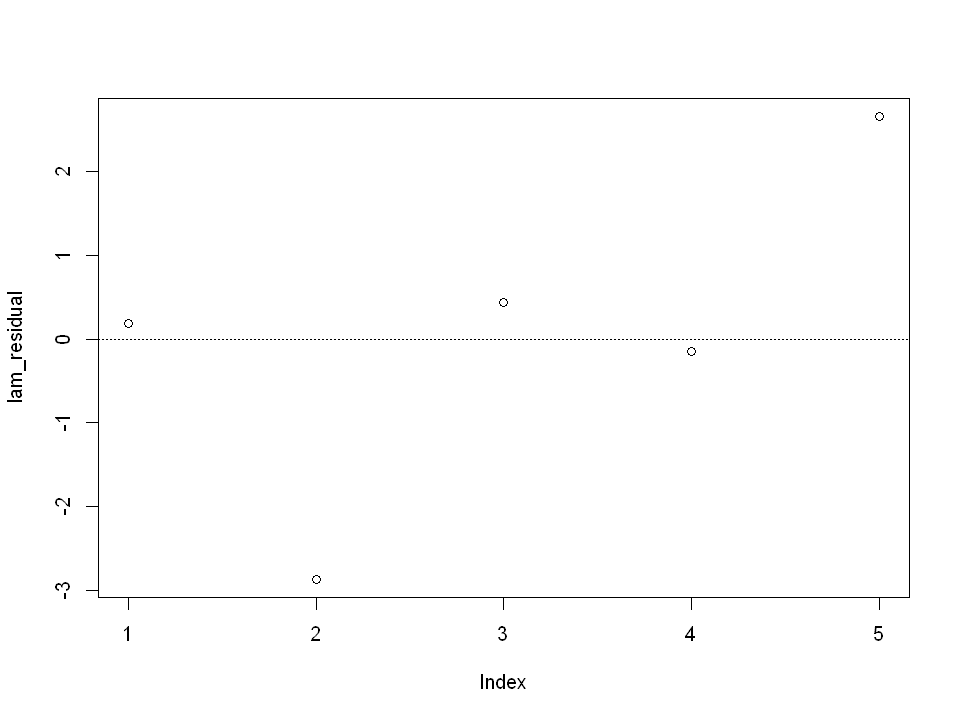

In [29]:
# Location level Residuals

lam_residual = pm_params[1:5] - pm_params["mu"]
plot(lam_residual)
abline(h=0, lty=3)

# We don’t see any obvious violations of our model assumptions.

# Results

In [30]:
summary(mod_sim)


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
lam[1]  9.282 0.5369 0.003100       0.003218
lam[2]  6.227 0.4615 0.002664       0.003092
lam[3]  9.530 0.5463 0.003154       0.003241
lam[4]  8.945 0.5266 0.003040       0.003085
lam[5] 11.755 0.6175 0.003565       0.004085
mu      9.096 0.9738 0.005622       0.008515
sig     2.075 0.7036 0.004062       0.008422

2. Quantiles for each variable:

         2.5%    25%    50%    75%  97.5%
lam[1]  8.266  8.911  9.273  9.636 10.367
lam[2]  5.353  5.912  6.211  6.528  7.171
lam[3]  8.494  9.154  9.517  9.890 10.640
lam[4]  7.940  8.587  8.935  9.292  9.999
lam[5] 10.580 11.331 11.743 12.161 13.006
mu      7.199  8.491  9.069  9.670 11.099
sig     1.097  1.583  1.944  2.421  3.801


# Another Example

In [31]:
dat = read.csv(file="pctgrowth.csv", header=TRUE)

head(dat)

y,grp
1.2,1
1.4,1
-0.5,1
0.3,1
0.9,1
2.3,1


In [32]:
unique(dat$grp)

[1] 1 2 3 4 5

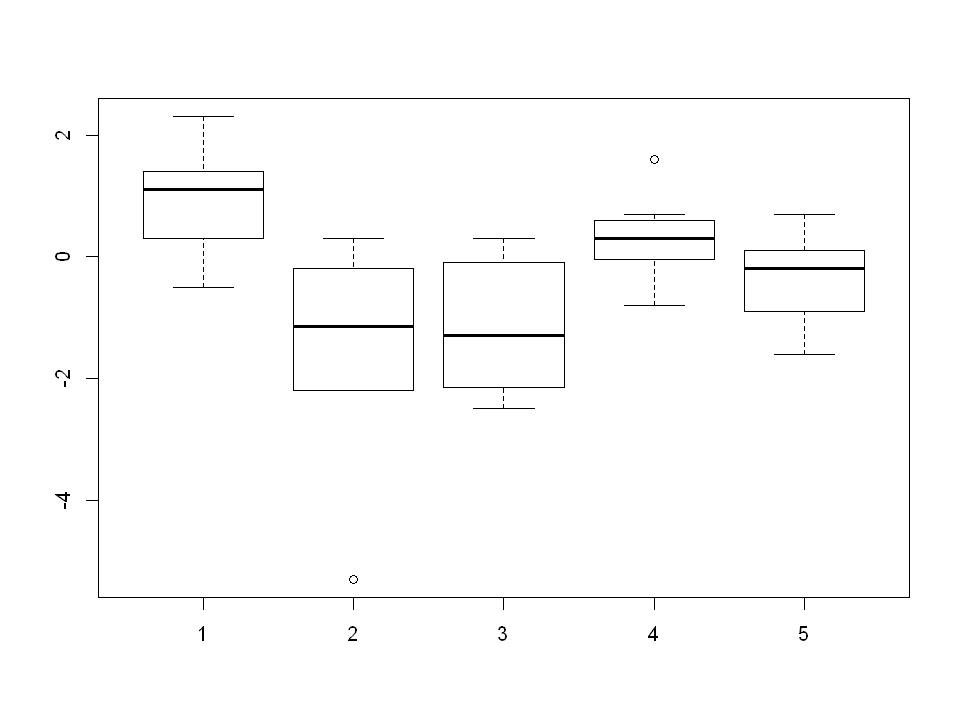

In [33]:
boxplot(y ~ grp, data = dat)

In [51]:
mod_str = " model {
    # Model's Likelihood Hierarchy
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu_grp[grp[i]], prec)
    }

    for(j in 1:max(grp)){
        mu_grp[j] ~ dnorm(mu, prec_grps)
    }
    
    # Priors
    mu ~ dnorm(0, 1/1e6)
    prec ~ dgamma(2/2.0, 2*1/2.0)
    prec_grps ~ dgamma(1/2.0, 1*3/2.0)

    #varaibles
    sig = 1/prec
    sig_grps =  1/prec_grps

} "

In [52]:
model = jags.model(textConnection(mod_str), 
                   data = as.list(dat), 
                   n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 53
   Unobserved stochastic nodes: 8
   Total graph size: 127

Initializing model



In [53]:
params = c("mu_grp", "mu", "sig", "sig_grps")

In [60]:
mod_sim = coda.samples(model = model, 
                       variable.names = params, 
                       n.iter = 1e4)

mod_csim = as.mcmc(do.call(rbind, mod_sim))

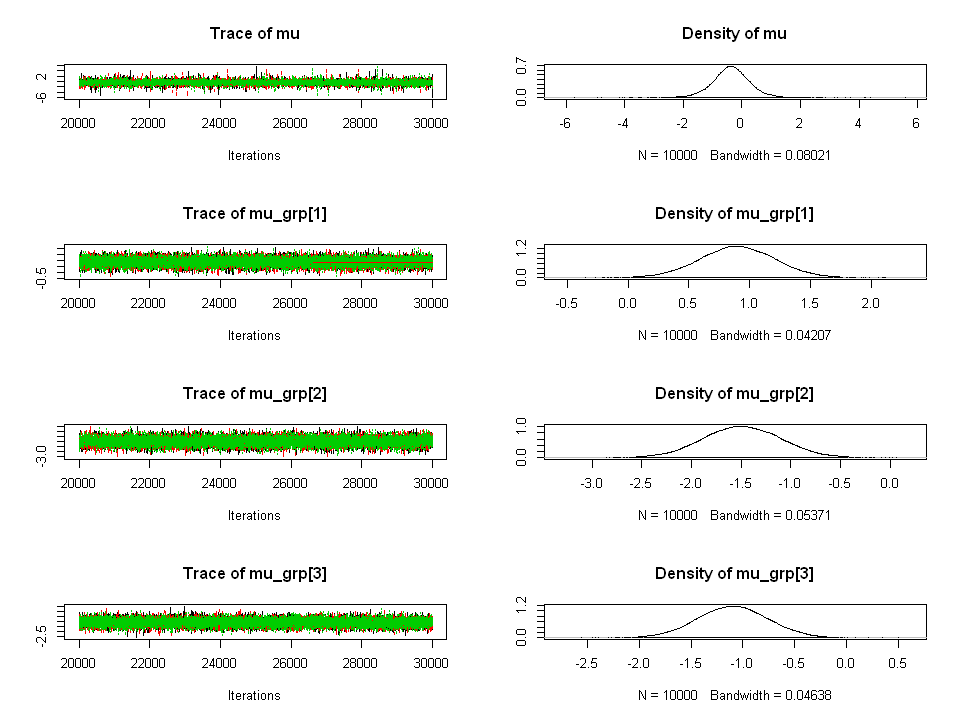

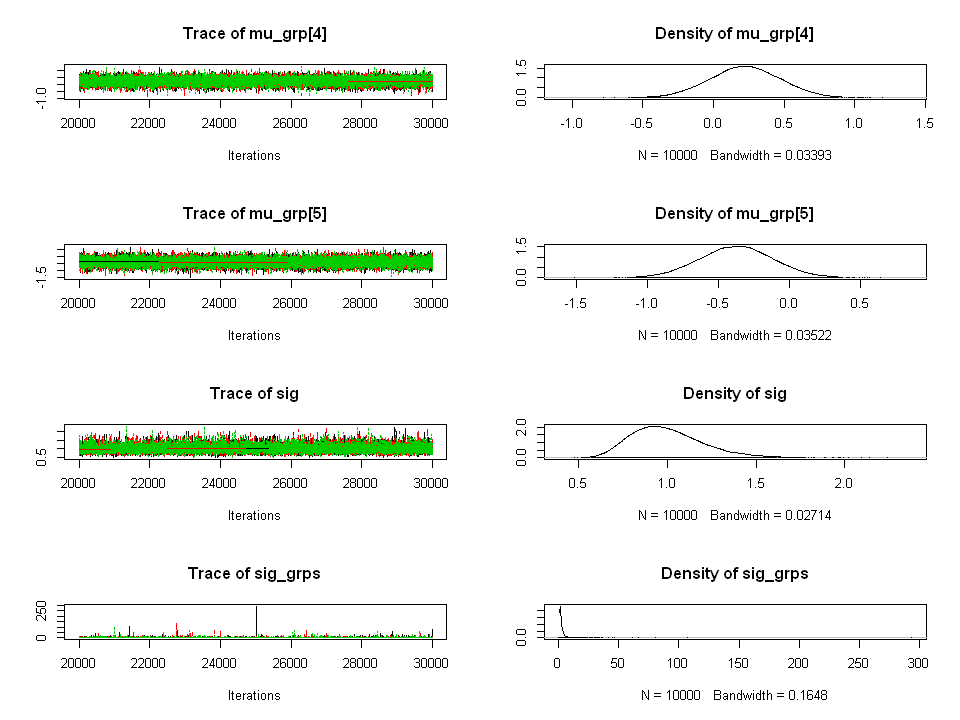

In [61]:
plot(mod_sim)

In [72]:
gelman.diag(mod_sim)
autocorr.diag(mod_sim)
effectiveSize(mod_sim)

Potential scale reduction factors:

          Point est. Upper C.I.
mu              1.00       1.00
mu_grp[1]       1.00       1.00
mu_grp[2]       1.00       1.00
mu_grp[3]       1.00       1.00
mu_grp[4]       1.00       1.00
mu_grp[5]       1.00       1.00
sig             1.00       1.00
sig_grps        1.02       1.02

Multivariate psrf

1

,mu,mu_grp[1],mu_grp[2],mu_grp[3],mu_grp[4],mu_grp[5],sig,sig_grps
Lag 0,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.0000000000,1.000000000
Lag 1,0.047009202,0.048732973,0.064431936,0.029640793,0.024271122,0.027449194,0.0972906518,0.190684648
Lag 5,-0.001216101,0.008353765,0.001470163,0.001754329,0.007333394,0.005873229,-0.0067783378,-0.002072516
Lag 10,-0.004532311,0.002516124,-0.007086858,0.003374025,-0.008556482,0.010879192,0.0032631002,-0.009338486
Lag 50,0.001422383,-0.005008029,-0.002966232,0.008757688,0.003492457,-0.005676707,-0.0001816587,0.019804808


mu mu_grp[1] mu_grp[2] mu_grp[3] mu_grp[4] mu_grp[5]       sig  sig_grps 
 26912.45  26599.46  26062.97  27044.71  27833.86  28355.91  25222.99  19921.89

In [73]:
colMeans(mod_csim)[2:6]

mu_grp[1]  mu_grp[2]  mu_grp[3]  mu_grp[4]  mu_grp[5] 
 0.8960922 -1.4895697 -1.0966352  0.2239774 -0.3720127

In [74]:
means_anova = tapply(dat$y, INDEX=dat$grp, FUN=mean)

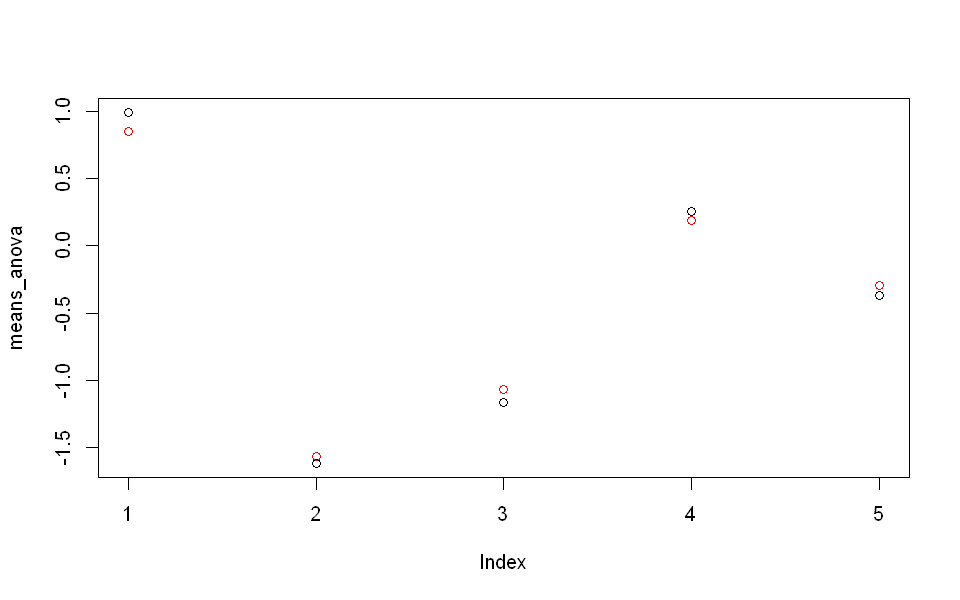

In [77]:
options(repr.plot.width=8, repr.plot.height=5)

plot(means_anova)
points(jitter(colMeans(mod_csim)[2:6]), col="red")

# The estimates from the hierarchical model have less variability than those from the ANOVA model, 
# tending toward smaller magnitudes.